In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import CuDNNLSTM, Dense, Flatten
from keras.models import Sequential
from keras import backend as K
from random import shuffle

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../data/wiki_movie_plots_deduped.csv")

In [3]:
# Keep only horror movies
keep_idx = df["Genre"].apply(lambda x: "horror" in x.lower())
df = df[keep_idx].copy()

df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
44,1912,Dr. Jekyll and Mr. Hyde,American,Lucius Henderson,James Cruze,horror,https://en.wikipedia.org/wiki/Dr._Jekyll_and_M...,White-haired Dr. Jekyll has secretly locked hi...
55,1913,Dr. Jekyll and Mr. Hyde,American,Herbert Brenon and Carl Laemmle,King Baggot,horror,https://en.wikipedia.org/wiki/Dr._Jekyll_and_M...,Dr. Henry Jekyll (King Baggot) sends a note to...
61,1914,The Avenging Conscience,American,D. W. Griffith,"Henry B. Walthall, Blanche Sweet","drama, horror",https://en.wikipedia.org/wiki/The_Avenging_Con...,A young man (Henry B. Walthall) falls in love ...
318,1920,Dr. Jekyll and Mr. Hyde,American,John S. Robertson,John Barrymore,horror,https://en.wikipedia.org/wiki/Dr._Jekyll_and_M...,Henry Jekyll (John Barrymore) is a doctor of m...
422,1922,A Blind Bargain,American,Wallace Worsley,"Lon Chaney, Raymond McKee",horror,https://en.wikipedia.org/wiki/A_Blind_Bargain,"The film is a contemporary (1920s, though the ..."


In [4]:
# Create flag indicating movie will be used for validation (80/20 split)
df["validate"] = np.random.uniform(size=df.shape[0]) < 0.2

In [5]:
# Fit character level tokenizer on plot descriptions
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df["Plot"])

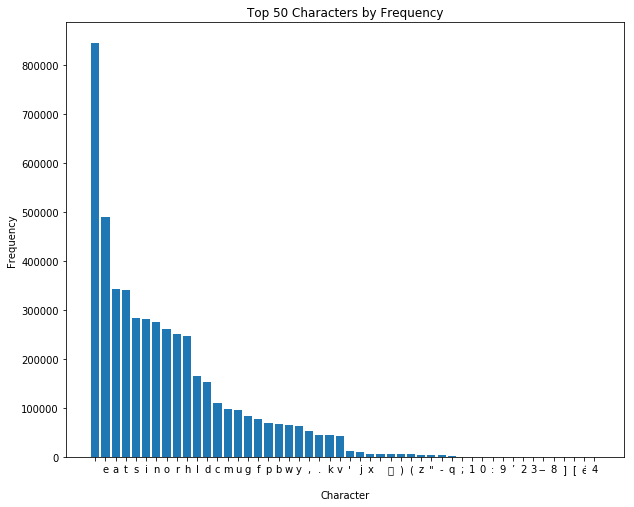

In [6]:
wc = tokenizer.word_counts
wc = sorted(wc.items(), key = lambda x: x[1])
chars, cnts = zip(*wc)

ind = np.arange(50)

plt.figure(figsize=(10, 8))
plt.title("Top 50 Characters by Frequency")
plt.bar(ind, cnts[-50:][::-1])
plt.xticks(ind, chars[-50:][::-1])
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.show()

In [7]:
# Convert each text to sequence of indices
char_seq = tokenizer.texts_to_sequences(df["Plot"])

print("First 20 Character Indices of '%s'" %df["Title"].iloc[0])
chars = char_seq[0][:20]
print("Raw Text: %s" %df["Plot"].iloc[0][:20])
print("Characters: %s" %[tokenizer.index_word[x] for x in chars])
print("Indices: %s" %str(chars))

First 20 Character Indices of 'Dr. Jekyll and Mr. Hyde'
Raw Text: White-haired Dr. Jek
Characters: ['w', 'h', 'i', 't', 'e', '-', 'h', 'a', 'i', 'r', 'e', 'd', ' ', 'd', 'r', '.', ' ', 'j', 'e', 'k']
Indices: [20, 10, 6, 4, 2, 35, 10, 3, 6, 9, 2, 12, 1, 12, 9, 23, 1, 27, 2, 24]


In [8]:
WINDOW_SIZE = 50
STEP_SIZE = 3

train_data = []
val_data = []

# Iterate over all movies
for i in range(len(char_seq)):
    
    seq = char_seq[i]
    
    # Iterate over character indices with specified step size
    for j in range(0, len(seq), STEP_SIZE):
        
        # Get input sequence with length equal to window size
        seq_in = seq[:j][-WINDOW_SIZE:]  
        
        # Get next character
        next_char = seq[j]
        
        # Append as tuple to either train_data or val_data
        if df["validate"].iloc[i]:
            val_data.append((seq_in, next_char))
        else:
            train_data.append((seq_in, next_char))
        

In [9]:
print("Example Element from train_data")
i = np.random.choice(len(train_data))
print(train_data[i])

Example Element from train_data
([4, 8, 1, 3, 4, 4, 2, 7, 12, 1, 3, 1, 18, 3, 9, 4, 21, 1, 20, 6, 4, 10, 1, 21, 3, 5, 10, 23, 1, 4, 10, 2, 9, 2, 1, 5, 10, 2, 1, 6, 5, 1, 18, 8, 5, 5, 2, 5, 5, 2], 12)


In [10]:
n_movies = df.shape[0]
n_validate = df["validate"].sum()
n_train = n_movies - n_validate

n_docs = len(train_data)
n_chars = max(tokenizer.index_word.keys())

print("Total Number of Movies: %i" % n_movies)
print("Total Number of Movies (Training): %i" % n_train)
print("Total Number of Movies (Validate): %i" % n_validate)
print("Total Number of Characters: %i" % sum(tokenizer.word_counts.values()))
print("Number of Unique Characters: %i" % n_chars)
print("Number of Input Text Segments (Training): %i" % len(train_data))
print("Number of Input Text Segments (Validation): %i" % len(val_data))

Total Number of Movies: 1587
Total Number of Movies (Training): 1264
Total Number of Movies (Validate): 323
Total Number of Characters: 4939318
Number of Unique Characters: 177
Number of Input Text Segments (Training): 1316214
Number of Input Text Segments (Validation): 330763


In [11]:
def generator(samples, max_length, one_hot_length, batch_size=32):
    
    while True:
        
        # Shuffle samples for each epoch
        shuffle(samples)
        
        # Iterate over all elements in samples 
        for i in range(0, len(samples), batch_size):
            
            # Subset batch of samples and unpack values
            X, y = zip(*samples[i:i + batch_size])
        
            # Zero pad input sequences
            X = pad_sequences(X, maxlen=max_length)
            
            # One hot encode input and output
            X = X.reshape(-1, max_length, 1) == np.arange(one_hot_length).reshape(1, -1)
            y = np.array(y).reshape(-1, 1) == np.arange(one_hot_length).reshape(1, -1)
            
            yield X, y

In [12]:
BATCH_SIZE  = 1024
train_gen = generator(train_data, max_length=WINDOW_SIZE, one_hot_length=n_chars, batch_size=BATCH_SIZE)
validate_gen = generator(train_data, max_length=WINDOW_SIZE, one_hot_length=n_chars, batch_size=BATCH_SIZE)

In [13]:
# Define model architecture
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(WINDOW_SIZE, n_chars)))
model.add(Dense(n_chars, activation="softmax"))

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="RMSprop")

In [17]:
NUM_EPOCHS = 1
train_steps = np.ceil(len(train_data) / BATCH_SIZE).astype(int)
val_steps = np.ceil(len(val_data) / BATCH_SIZE).astype(int)

history = model.fit_generator(train_gen, epochs=NUM_EPOCHS, 
                              steps_per_epoch=train_steps,
                              validation_data=validate_gen, 
                              validation_steps=val_steps)

Epoch 1/1
1286/1286 [==============================] - 88s 68ms/step - loss: 2.4712 - val_loss: 2.2295


In [18]:
model.save("../models/plot_generator.hd5")

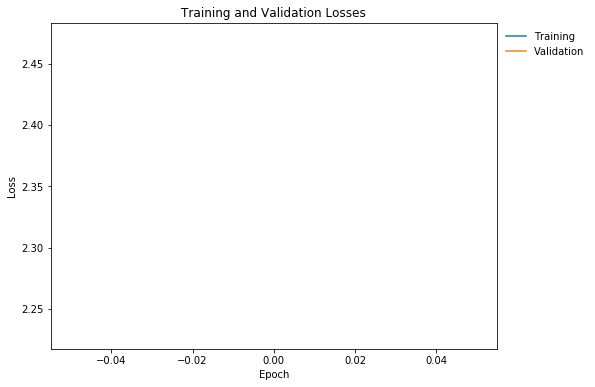

In [19]:
plt.figure(figsize=(8, 6))
plt.title("Training and Validation Losses")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend(frameon=False, loc=2, bbox_to_anchor=(1,1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Generating the Plots

In [71]:
def smooth_preds(preds, k=1.0):
    log_preds = np.log(preds) / k
    exp_preds = np.exp(log_preds)
    return exp_preds / exp_preds.sum()

def sample_character(preds, smooth_factor, idx_to_char):

    # Character indices
    ind = np.arange(1, len(preds) + 1)
    
    # Smooth predictions
    
    # Sample from character indices
    preds_smooth = smooth_preds(preds, smooth_factor)
    samp_idx = np.random.choice(ind, p=preds_smooth)
    
    return idx_to_char[samp_idx]

In [106]:
x = np.zeros(shape=(1, 50, 177))
x[0, 49, 10] = 1
p = model.predict_proba(x)

In [98]:
sample_character(np.zeros(178), 1.0, idx_to_char=tokenizer.index_word)

C:\Users\jrobi\Miniconda3\envs\tf_venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\jrobi\Miniconda3\envs\tf_venv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\jrobi\Miniconda3\envs\tf_venv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


' '

<BarContainer object of 177 artists>

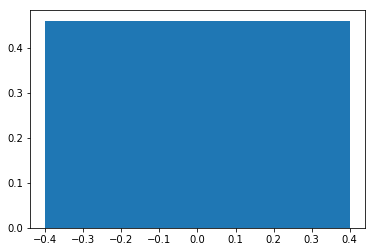

In [107]:
ind = np.arange(len(p))
plt.bar(ind, p.flatten())

In [96]:
p.shape

(1, 177)